# Data Glacier  Internship

## Author: Lauro Ribeiro, Buse Güngör, Salmah 
We create a model to predict according to a customer's behavior whether or not this customer will buy a Bank`s product based on their last month behaviour.

In [1]:
##### Import packages
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# To avoid warnings´
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
##### Import data
# Check the path before running it

df = pd.read_pickle('/content/drive/MyDrive/DataGlacier-GroupProject/data_modelling_memred.pkl')

In [3]:
##### I create a numerical series -- I need to predict 17th month

dict_meses = dict()
for num,value in enumerate(df.fecha_dato.unique(),1):
    dict_meses[value] = num
    
df["month_counter"] = df['fecha_dato'].map(dict_meses)

In [4]:
##### Due to imputation strategy, I reapply previous filter to prevent unexpected values 

info_17 = df.ncodpers.value_counts()[df.ncodpers.value_counts() == 17].index
df = df[df['ncodpers'].isin(info_17)].reset_index(drop = True)

# Prediction Model for `ind_cco_fin_ult1`

In [5]:
##### I extract the other 15 rows from the first product purchase column and transpose it

df_product = pd.DataFrame()
for i in range(0,17):
    x = df.query(f'month_counter == {i}')["ind_cco_fin_ult1"].tolist()
    df1 = pd.DataFrame(x).T
    df_product = pd.concat([df1,df_product], axis=0)
    
df_product = df_product.T
df_product.columns = range(1,17)
df_product

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1
1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
2,1,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1
3,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
4,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296817,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1
296818,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1
296819,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
296820,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1


In [6]:
##### I keep only relevant columns (product column will have a special processing)

df_pred = df[['month', 'sexo', 'age', 'antiguedad','tiprel_1mes', 'canal_entrada', 'nomprov', 'renta', 'segmento']].copy()

df_pred.head()

,month,sexo,age,antiguedad,tiprel_1mes,canal_entrada,nomprov,renta,segmento
0,1,V,23,35,A,KHE,ZARAGOZA,451931.22,03 - UNIVERSITARIO
1,1,H,23,35,A,KHE,ZARAGOZA,113316.66,03 - UNIVERSITARIO
2,1,H,23,35,A,KHE,ZAMORA,113538.81,03 - UNIVERSITARIO
3,1,V,23,35,A,KHE,BARCELONA,451931.22,03 - UNIVERSITARIO
4,1,V,24,35,I,KHE,SALAMANCA,68318.46,03 - UNIVERSITARIO


In [7]:
##### See which ones need data preparation based on unique values

for col in df_pred.columns:
    print(f'{col}: {df_pred[col].unique()}')

month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
sexo: ['V' 'H']
age: [ 23  24  22  28  25  37  39  63  33  32  42  38  50  30  31  45  27  26
  60  36  29  34  48  35  54  44  57  84  83  47  40  77  69  52  43  46
  49  67  51  78  41  55  59  53  73  62  66  68  65  79  19  58  56  86
  64  61  20  72  89  71  21  96  80  95  81  82  70  76  92  93  18  74
  75  85  91  87  90  98  88  94  99  97 100]
antiguedad: [     35      31      16      34       9      29      10      24      27
       7      33      14       6      12      26      23      21      11
      28       4      17      22      18       8      13      20      32
      15      25      36      40      19      38      37      39      30
       3       5      47      46      44      43      45      41      57
      56      50      58      52      48      49      54      55      53
      51      59      42      62      61      60      63       1       2
     139     165     164      94     159     105     162     137     128


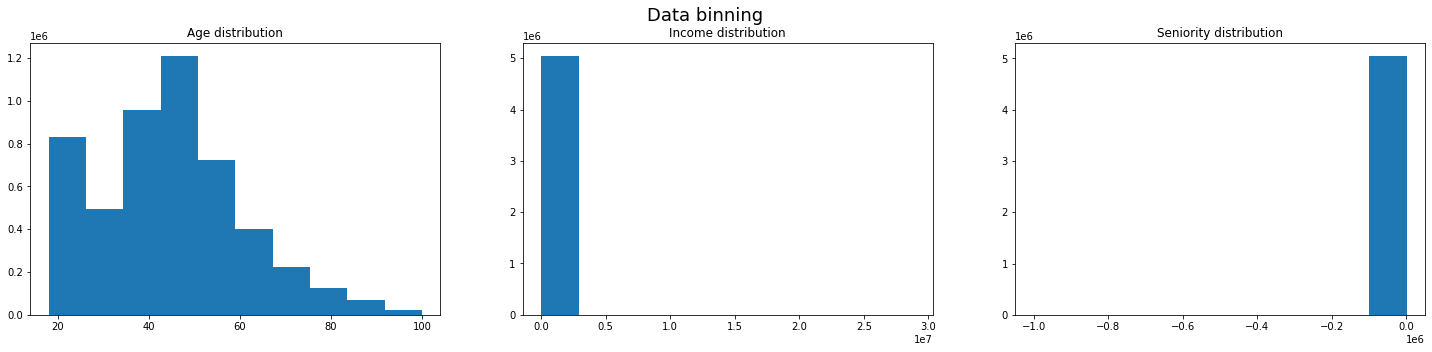

In [8]:
##### Data binning to age, renta and antiguedad

fig, ax = plt.subplots(1,3, figsize = [25, 5])
fig.suptitle('Data binning', fontsize = 18)

# Age
ax[0].hist(df_pred.age)
ax[0].set_title('Age distribution', fontsize = 12)

bins = np.linspace(df_pred.age.min(), df_pred.age.max(), 5)
# Young = 0 | Adult = 1 | Senior = 2 | Elderly = 3
df_pred['age_binning'] = pd.cut(df_pred['age'], bins, labels = [0,1,2,3], include_lowest=True)
del df_pred['age']

# Renta
ax[1].hist(df_pred.renta)
ax[1].set_title('Income distribution', fontsize = 12)

bins = np.linspace(df_pred.renta.min(), df_pred.renta.max(), 5)
# Low = 0 | Middle = 1 | Middle-High = 2 | High = 3
df_pred['renta_binning'] = pd.cut(df_pred['renta'], bins, labels = [0,1,2,3], include_lowest=True)
del df_pred['renta']

# Antiguedad
ax[2].hist(df_pred.antiguedad)
ax[2].set_title('Seniority distribution', fontsize = 12)

bins = np.linspace(df_pred.antiguedad.min(), df_pred.antiguedad.max(), 5)
# Baja = 0 | Media = 1 | Media Alta = 2 | Alta = 3
df_pred['antiguedad_binning'] = pd.cut(df_pred['antiguedad'], bins, labels = [0,1,2,3], include_lowest=True)
del df_pred['antiguedad']

In [9]:
##### To dummy to sexo, tiprel_1mes and canal_entrada

for col in ["sexo", "tiprel_1mes","canal_entrada"]:
    df_pred = df_pred.join(pd.get_dummies(df_pred[col], prefix = col))
    
for col in ["sexo", "tiprel_1mes","canal_entrada", "sexo_V", "tiprel_1mes_I"]:
    del df_pred[col]

In [10]:
##### Label Encoding to nomprov and segmento

for col in ['nomprov', 'segmento']:
    LabelEncoding = LabelEncoder()
    df_pred[col] = LabelEncoding.fit_transform(df_pred[col].values)

In [11]:
##### Now I join both DataFrames

df_product = df_product.join(df_pred)
df_product

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,month,nomprov,segmento,age_binning,renta_binning,antiguedad_binning,sexo_H,tiprel_1mes_A,canal_entrada_KAT,canal_entrada_KFC,canal_entrada_KHE,canal_entrada_otros
0,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,51,2,0,0,3,0,1,0,0,1,0
1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,51,2,0,0,3,1,1,0,0,1,0
2,1,1,1,1,0,1,1,0,0,1,1,1,1,1,0,1,1,50,2,0,0,3,1,1,0,0,1,0
3,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,8,2,0,0,3,0,1,0,0,1,0
4,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,40,2,0,0,3,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296817,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,30,1,2,0,3,1,1,0,0,0,1
296818,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,1,30,0,1,0,3,1,1,0,0,0,1
296819,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,30,1,1,0,3,1,1,1,0,0,0
296820,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,30,1,2,0,3,1,1,0,0,0,1


In [12]:
##### Creation of X and y

X = np.asarray(df_product.values)
y = np.asarray(df.query(f'month_counter == 17')["ind_cco_fin_ult1"]) # target is last month

In [13]:
##### Creation of X and y train/test

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)

In [14]:
##### Undersampling to create sintetic data to improve class balance.
# Increase minority class size until its size represent 80% of major class size

undersampling = RandomUnderSampler(sampling_strategy=0.8) 
X_balance, y_balance = undersampling.fit_resample(X, y)
Counter(y_balance)

Counter({0: 78567, 1: 98208})

In [15]:
##### Creation of X and y split -- train and test applying undersampling

X_train_balance, X_test_balance, y_train_balance, y_test_balance = train_test_split(X_balance, y_balance, test_size=0.4)

## Logistic Regression

In [16]:
##### Logistic Regression 

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

print('Accuracy score: ',accuracy_score(y_test,yhat))

Accuracy score:  0.7358698215549092


In [17]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000     23520
           1      0.736     1.000     0.848     65527

    accuracy                          0.736     89047
   macro avg      0.368     0.500     0.424     89047
weighted avg      0.542     0.736     0.624     89047



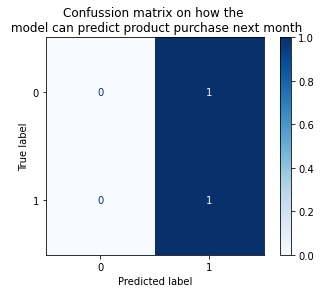

In [18]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict product purchase next month')
plt.show()

### With Undersampling

In [19]:
##### Logistic Regression with Undersampling

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_balance, y_train_balance)
yhat = clf.predict(X_test_balance)
print('Accuracy score: ',accuracy_score(y_test_balance, yhat))

Accuracy score:  0.5554518455663979


In [20]:
##### Classification Report

print(classification_report(y_test_balance, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.479     0.024     0.045     31370
           1      0.557     0.980     0.710     39340

    accuracy                          0.555     70710
   macro avg      0.518     0.502     0.378     70710
weighted avg      0.523     0.555     0.415     70710



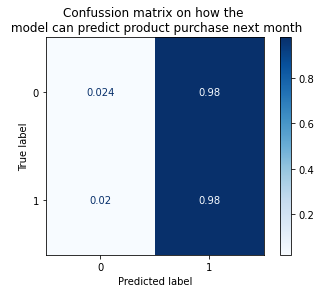

In [21]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test_balance, y_test_balance,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict product purchase next month')
plt.show()

## Random Forest Classifier

In [22]:
##### Random Forest Classifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Accuracy score: ',accuracy_score(y_test,yhat))

Accuracy score:  0.6984738396577088


In [23]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.265     0.080     0.123     23520
           1      0.736     0.920     0.818     65527

    accuracy                          0.698     89047
   macro avg      0.501     0.500     0.471     89047
weighted avg      0.612     0.698     0.634     89047



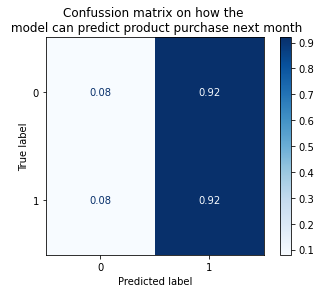

In [24]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict product purchase next month')
plt.show()

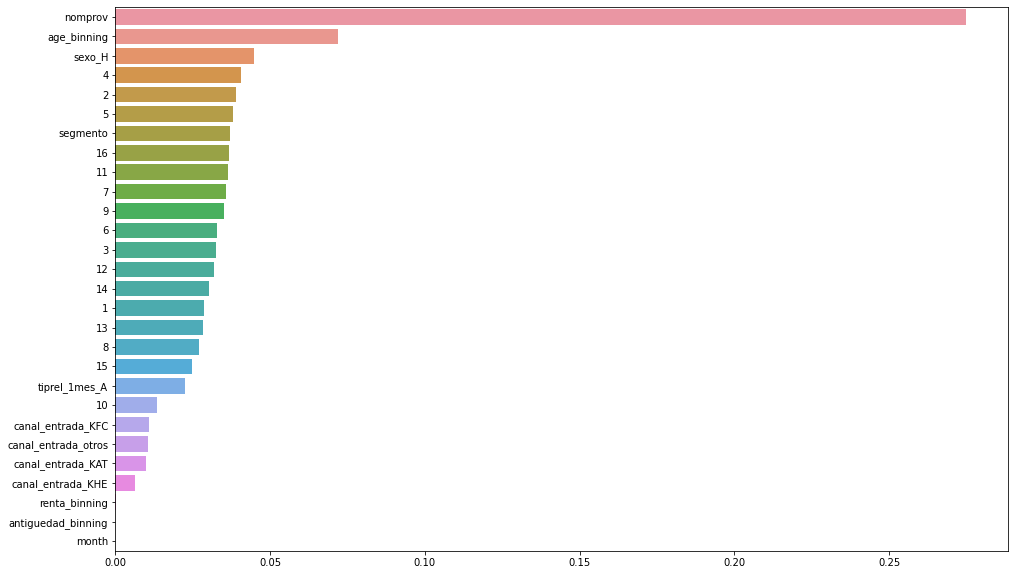

In [25]:
##### Feature Importance

features_importance = clf.feature_importances_
features_array = np.array(df_product.columns)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y = features_array, x = features_importance, orient='h', order=features_array_ordered[:50])

plt.show()

### With Undersampling

In [26]:
##### Random Forest Classifier with Undersampling

clf = RandomForestClassifier()
clf.fit(X_train_balance, y_train_balance)
yhat = clf.predict(X_test_balance)
print('Accuracy score: ',accuracy_score(y_test_balance,yhat))

Accuracy score:  0.5166595955310422


In [27]:
##### Classification Report

print(classification_report(y_test_balance, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.446     0.368     0.403     31370
           1      0.558     0.635     0.594     39340

    accuracy                          0.517     70710
   macro avg      0.502     0.502     0.499     70710
weighted avg      0.508     0.517     0.509     70710



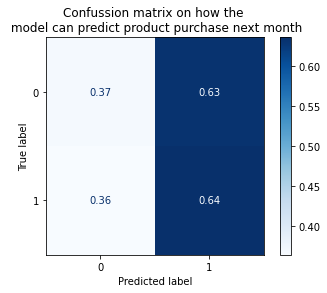

In [28]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test_balance, y_test_balance,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict product purchase next month')
plt.show()

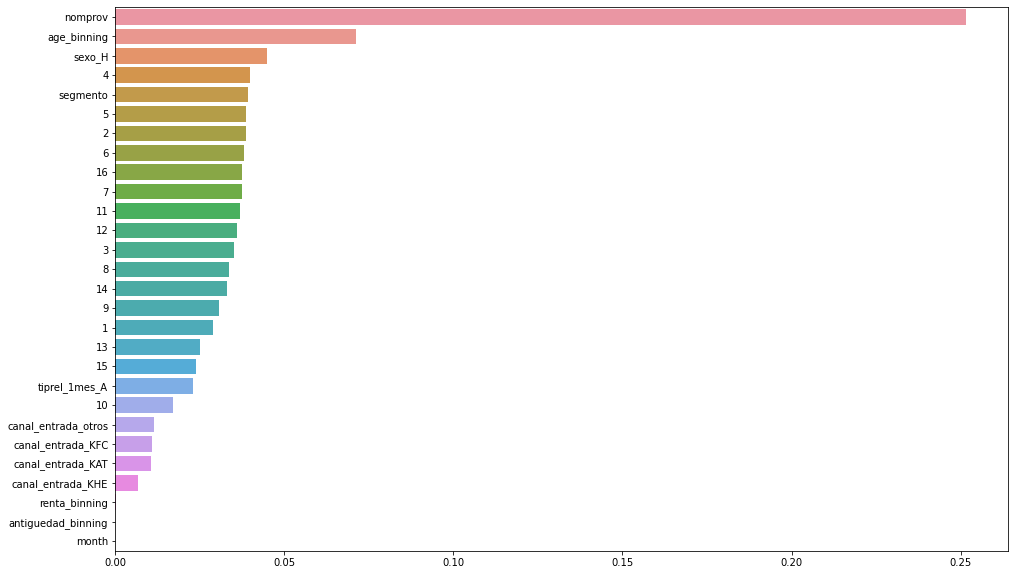

In [29]:
##### Feature Importance

features_importance = clf.feature_importances_
features_array = np.array(df_product.columns)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y = features_array, x = features_importance, orient='h', order=features_array_ordered[:50])

plt.show()

## XGB Classifier

In [30]:
##### XGB Classifier

clf = XGBClassifier() 
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Accuracy score: ',accuracy_score(y_test, yhat))

Accuracy score:  0.7358698215549092


In [31]:
##### Classification Report

print(classification_report(y_test, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000     23520
           1      0.736     1.000     0.848     65527

    accuracy                          0.736     89047
   macro avg      0.368     0.500     0.424     89047
weighted avg      0.542     0.736     0.624     89047



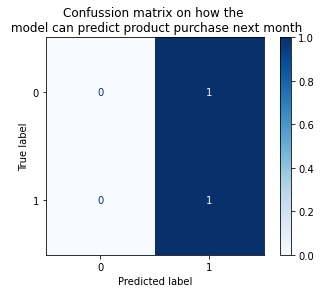

In [32]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict product purchase next month')
plt.show()

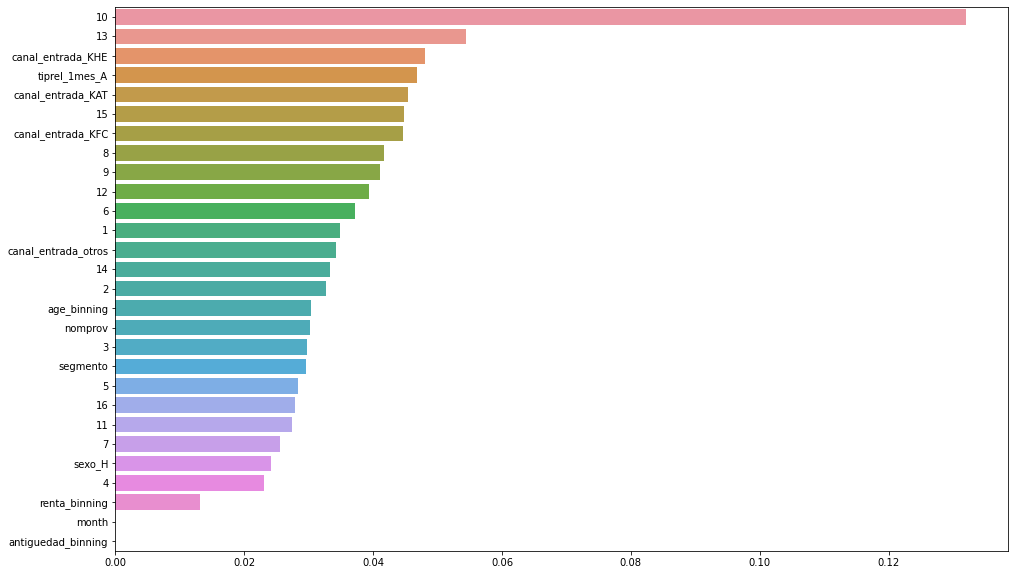

In [33]:
##### Feature Importance

features_importance = clf.feature_importances_
features_array = np.array(df_product.columns)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y = features_array, x = features_importance, orient='h', order=features_array_ordered[:50])

plt.show()

### With Undersampling

In [34]:
##### XGB Classifier

clf = XGBClassifier() 
clf.fit(X_train_balance, y_train_balance)
yhat = clf.predict(X_test_balance)
print('Accuracy score: ',accuracy_score(y_test_balance, yhat))

Accuracy score:  0.5557488332626219


In [35]:
##### Classification Report

print(classification_report(y_test_balance, yhat, digits=3))

              precision    recall  f1-score   support

           0      0.489     0.030     0.057     31370
           1      0.558     0.975     0.709     39340

    accuracy                          0.556     70710
   macro avg      0.523     0.503     0.383     70710
weighted avg      0.527     0.556     0.420     70710



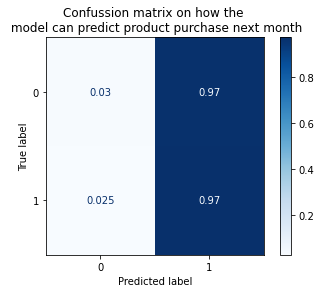

In [36]:
##### Confussion Matrix

plot_confusion_matrix(clf, X_test_balance, y_test_balance,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues,
                             normalize="true")
plt.title('Confussion matrix on how the \n model can predict product purchase next month')
plt.show()

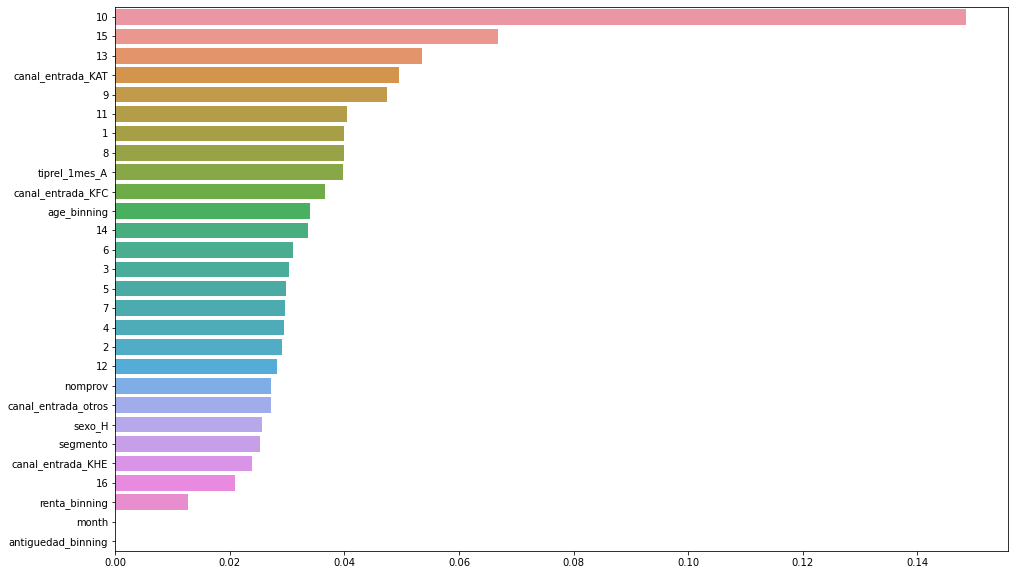

In [37]:
##### Feature Importance

features_importance = clf.feature_importances_
features_array = np.array(df_product.columns)
features_array_ordered = features_array[(features_importance).argsort()[::-1]]
features_array_ordered

plt.figure(figsize=(16,10))
sns.barplot(y = features_array, x = features_importance, orient='h', order=features_array_ordered[:50])

plt.show()